In [1]:
# from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
import pyranges as pr
import requests
import os
import pandas as pd
import glob
import pickle

In [2]:
%load_ext lab_black

# Plot

In [3]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pyBigWig
import seaborn as sns
from pybedtools import BedTool
import re

import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [4]:
tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14_monocyte": "CD14+\nmonocytes",
    "CD4_T_cell": "CD4+\nT cells",
    "Cytotoxic_T_cell": "CD8+\nT cells",
    "Dendritic_cell": "Dendritic\ncells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+\nmonocytes",
}

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [5]:
merged_dar_path_dict = {
    x.split("/")[-1].split("__")[1].split("_VS")[0]: x
    for x in glob.glob("downstream_analysis/DARs/*/*.bed")
}
merged_dar_path_dict

{'s3atac_sampleB_CD14+_monocyte': 'downstream_analysis/DARs/s3atac/s3atac__s3atac_sampleB_CD14+_monocyte_VS_s3atac_sampleA_CD14+_monocyte__DARs.TOP2k.bed',
 's3atac_sampleB_Cytotoxic_T_cell': 'downstream_analysis/DARs/s3atac/s3atac__s3atac_sampleB_Cytotoxic_T_cell_VS_s3atac_sampleA_Cytotoxic_T_cell__DARs.unique.TOP2K.bed',
 's3atac_sampleA_CD14+_monocyte': 'downstream_analysis/DARs/s3atac/s3atac__s3atac_sampleA_CD14+_monocyte_VS_s3atac_sampleB_CD14+_monocyte__DARs.unique.bed',
 's3atac_sampleA_Cytotoxic_T_cell': 'downstream_analysis/DARs/s3atac/s3atac__s3atac_sampleA_Cytotoxic_T_cell_VS_s3atac_sampleB_Cytotoxic_T_cell__DARs.unique.bed',
 'ddseq_sampleB_B_cell': 'downstream_analysis/DARs/ddseq/ddseq__ddseq_sampleB_B_cell_VS_ddseq_sampleA_B_cell__DARs.TOP2k.bed',
 'ddseq_sampleA_Cytotoxic_T_cell': 'downstream_analysis/DARs/ddseq/ddseq__ddseq_sampleA_Cytotoxic_T_cell_VS_ddseq_sampleB_Cytotoxic_T_cell__DARs.TOP2k.bed',
 'ddseq_sampleA_B_cell': 'downstream_analysis/DARs/ddseq/ddseq__ddseq_s

In [6]:
merged_dar_path_dict = {
    y: merged_dar_path_dict[y]
    for y in [
        x
        for x in merged_dar_path_dict.keys()
        if ("B_cell" in x) or ("Cytotoxic_T_cell" in x) or ("CD4+_T_cell" in x)
    ]
}

In [7]:
regions_dict = OrderedDict({})
regions_maxstr_df = pd.DataFrame()
for sample, path in merged_dar_path_dict.items():
    print(sample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = sample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region
    supersample = sample.split("_")[0]
    cell_type = "_".join(sample.split("_")[1:])
    regions_maxstr_df.at[supersample, cell_type] = df.iloc[0]["log2fc"]

regions_dict

s3atac_sampleB_Cytotoxic_T_cell
s3atac_sampleA_Cytotoxic_T_cell
ddseq_sampleB_B_cell
ddseq_sampleA_Cytotoxic_T_cell
ddseq_sampleA_B_cell
ddseq_sampleB_Cytotoxic_T_cell
ddseq_sampleA_CD4+_T_cell
ddseq_sampleB_CD4+_T_cell
10xv1_sampleB_CD4+_T_cell
10xv1_sampleB_B_cell
10xv1_sampleA_Cytotoxic_T_cell
10xv1_sampleA_B_cell
10xv1_sampleA_CD4+_T_cell
10xv1_sampleB_Cytotoxic_T_cell
mtscatac_sampleA_B_cell
mtscatac_sampleA_CD4+_T_cell
mtscatac_sampleB_Cytotoxic_T_cell
mtscatac_sampleB_CD4+_T_cell
mtscatac_sampleB_B_cell
mtscatac_sampleA_Cytotoxic_T_cell
10xv2_sampleB_CD4+_T_cell
10xv2_sampleB_Cytotoxic_T_cell
10xv2_sampleA_B_cell
10xv2_sampleB_B_cell
10xv2_sampleA_Cytotoxic_T_cell
10xv2_sampleA_CD4+_T_cell
10xmultiome_sampleB_Cytotoxic_T_cell
10xmultiome_sampleA_B_cell
10xmultiome_sampleB_CD4+_T_cell
10xmultiome_sampleA_Cytotoxic_T_cell
10xmultiome_sampleA_CD4+_T_cell
10xmultiome_sampleB_B_cell
hydrop_sampleA_Cytotoxic_T_cell
hydrop_sampleB_Cytotoxic_T_cell
hydrop_sampleA_CD4+_T_cell
hydrop_samp

OrderedDict([('s3atac_sampleB_Cytotoxic_T_cell', 'chr12:6894090-6894590'),
             ('s3atac_sampleA_Cytotoxic_T_cell', 'chr12:10292828-10293328'),
             ('ddseq_sampleB_B_cell', 'chr7:5488513-5489013'),
             ('ddseq_sampleA_Cytotoxic_T_cell', 'chr19:41426581-41427081'),
             ('ddseq_sampleA_B_cell', 'chr16:31880421-31880921'),
             ('ddseq_sampleB_Cytotoxic_T_cell', 'chr16:3548364-3548864'),
             ('ddseq_sampleA_CD4+_T_cell', 'chr20:50194891-50195391'),
             ('ddseq_sampleB_CD4+_T_cell', 'chr6:11712754-11713254'),
             ('10xv1_sampleB_CD4+_T_cell', 'chr22:36816760-36817260'),
             ('10xv1_sampleB_B_cell', 'chr1:109503908-109504408'),
             ('10xv1_sampleA_Cytotoxic_T_cell', 'chr16:58177215-58177715'),
             ('10xv1_sampleA_B_cell', 'chr6:70666657-70667157'),
             ('10xv1_sampleA_CD4+_T_cell', 'chr11:9681646-9682146'),
             ('10xv1_sampleB_Cytotoxic_T_cell', 'chr18:26708750-26709250'),
    

In [8]:
regions_maxstr_df

,sampleB_Cytotoxic_T_cell,sampleA_Cytotoxic_T_cell,sampleB_B_cell,sampleA_B_cell,sampleA_CD4+_T_cell,sampleB_CD4+_T_cell
s3atac,0.537627,0.226693,NaN,NaN,NaN,NaN
ddseq,0.821580,1.072721,1.076297,2.152992,1.292236,1.066733
10xv1,1.900956,0.670953,1.580889,1.742505,1.123186,1.150943
mtscatac,0.565792,0.560568,0.907518,0.745828,0.746014,0.991810
10xv2,1.856757,0.588514,0.832993,1.668839,1.158081,0.885774
10xmultiome,1.320006,0.594601,0.638410,0.898787,0.715533,0.578385
hydrop,0.532127,0.417732,0.647265,0.637100,0.481483,0.933123
10xv11,1.293122,0.793041,1.020363,1.638865,0.468253,1.339407


## alternatively, use merged DARs

In [9]:
merged_dar_path_dict = {
    x.split("/")[-1].split("_VS")[0].replace("+", ""): x
    for x in glob.glob("../fixedcells_4_merged/merged_male_female_DARs/*.bed")
}
merged_dar_path_dict

{'sampleA_CD14_monocyte': '../fixedcells_4_merged/merged_male_female_DARs/sampleA_CD14+_monocyte_VS_sampleB_CD14+_monocyte__1-0xfoldchange_DARs.top200.bed',
 'sampleB_CD14_monocyte': '../fixedcells_4_merged/merged_male_female_DARs/sampleB_CD14+_monocyte_VS_sampleA_CD14+_monocyte__1-0xfoldchange_DARs.bed',
 'sampleA_B_cell': '../fixedcells_4_merged/merged_male_female_DARs/sampleA_B_cell_VS_sampleB_B_cell__1-0xfoldchange_DARs.bed',
 'sampleA_CD4_T_cell': '../fixedcells_4_merged/merged_male_female_DARs/sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell__1-0xfoldchange_DARs.top200.bed',
 'sampleB_Dendritic_cell': '../fixedcells_4_merged/merged_male_female_DARs/sampleB_Dendritic_cell_VS_sampleA_Dendritic_cell__1-0xfoldchange_DARs.bed',
 'sampleA_Cytotoxic_T_cell': '../fixedcells_4_merged/merged_male_female_DARs/sampleA_Cytotoxic_T_cell_VS_sampleB_Cytotoxic_T_cell__1-0xfoldchange_DARs.top200.bed',
 'sampleA_Dendritic_cell': '../fixedcells_4_merged/merged_male_female_DARs/sampleA_Dendritic_cell_VS_sa

In [10]:
regions_dict = OrderedDict({})
regions_maxstr_df = pd.DataFrame()
for sample, path in merged_dar_path_dict.items():
    print(sample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = sample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region
    supersample = sample.split("_")[0]
    cell_type = "_".join(sample.split("_")[1:])
    regions_maxstr_df.at[supersample, cell_type] = df.iloc[0]["log2fc"]

regions_dict

sampleA_CD14_monocyte
sampleB_CD14_monocyte
sampleA_B_cell
sampleA_CD4_T_cell
sampleB_Dendritic_cell
sampleA_Cytotoxic_T_cell
sampleA_Dendritic_cell
sampleB_Natural_killer_cell
sampleA_CD16_monocyte
sampleB_CD16_monocyte
sampleB_B_cell
sampleA_Natural_killer_cell
sampleB_CD4_T_cell
sampleB_Cytotoxic_T_cell


OrderedDict([('sampleA_CD14_monocyte', 'chr19:38579230-38579730'),
             ('sampleB_CD14_monocyte', 'chrX:118992700-118993200'),
             ('sampleA_B_cell', 'chr5:158390608-158391108'),
             ('sampleA_CD4_T_cell', 'chr2:111634294-111634794'),
             ('sampleB_Dendritic_cell', 'chr15:40493445-40493945'),
             ('sampleA_Cytotoxic_T_cell', 'chr9:91694416-91694916'),
             ('sampleA_Dendritic_cell', 'chr5:35819594-35820094'),
             ('sampleB_Natural_killer_cell', 'chr3:141300368-141300868'),
             ('sampleA_CD16_monocyte', 'chr12:69275483-69275983'),
             ('sampleB_CD16_monocyte', 'chr3:15500218-15500718'),
             ('sampleB_B_cell', 'chr20:62025976-62026476'),
             ('sampleA_Natural_killer_cell', 'chr2:144376443-144376943'),
             ('sampleB_CD4_T_cell', 'chr15:40746390-40746890'),
             ('sampleB_Cytotoxic_T_cell', 'chr17:1614118-1614618')])

In [ ]:
sampleA_B_cell_VS_sampleB_B_cell
chr19:4214712-4215211
Score = 0.8278824

In [188]:
regions_dict = {
    "sampleA_Cytotoxic_T_cell": "chr11:112525183-112525683",
    "sampleB_Cytotoxic_T_cell": "chr11:112525183-112525683",
    "sampleA_CD4_T_cell": "chr22:26547369-26547868",
    "sampleB_CD4_T_cell": "chr22:26547369-26547868",
    "sampleA_B_cell": "chr10:50508215-50508714",
    "sampleB_B_cell": "chr10:50508215-50508714",
}

In [263]:
regions_dict = {
    "sampleA_Cytotoxic_T_cell": "chr11:112525183-112525683",
    "sampleB_Cytotoxic_T_cell": "chr11:112525183-112525683",
    "sampleA_CD4_T_cell": "chr22:26547369-26547868",
    "sampleB_CD4_T_cell": "chr22:26547369-26547868",
    "sampleA_B_cell": "chr19:4214712-4215211",
    "sampleB_B_cell": "chr19:4214712-4215211",
}

In [264]:
regions_df = pd.DataFrame(columns=["chrom", "start", "end"])
for key in regions_dict.keys():
    row = list(regions_dict.keys()).index(key)
    chrom, start, end = re.split(":|-", regions_dict[key])
    start = int(re.sub(",", "", start))
    end = int(re.sub(",", "", end))

    region = pd.DataFrame(columns=["chrom", "start", "end"], index=[key])
    region["chrom"] = chrom
    region["start"] = start
    region["end"] = end
    regions_df = pd.concat([regions_df, region], axis=0)

bedtool_obj = BedTool.from_dataframe(df=regions_df)

regions_df

,chrom,start,end
sampleA_Cytotoxic_T_cell,chr11,112525183,112525683
sampleB_Cytotoxic_T_cell,chr11,112525183,112525683
sampleA_CD4_T_cell,chr22,26547369,26547868
sampleB_CD4_T_cell,chr22,26547369,26547868
sampleA_B_cell,chr19,4214712,4215211
sampleB_B_cell,chr19,4214712,4215211


genes to plot

In [303]:
genes_dict = {
    "sampleA_Cytotoxic_T_cell": ["LINC02763"],
    "sampleB_Cytotoxic_T_cell": ["LINC02763"],
    "sampleA_CD4_T_cell": ["TPST2"],
    "sampleB_CD4_T_cell": ["TPST2"],
    "sampleA_B_cell": ["ANKRD24"],
    "sampleB_B_cell": ["ANKRD24"],
}
max_genes = max([len((genes_dict[key])) for key in genes_dict.keys()])

gtf_file = "/lustre1/project/stg_00090/scatac_benchmark/0_resources/genomes/hg38_cflerin_cellranger_arc/genes.ucsc.gtf"

In [304]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob("male_female_coverage/*bw_files/*")
        ]
    )
)
cell_types = regions_df.index

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type.replace("+", "")] = {
        x.split("/")[-2].split("__")[0]: x
        for x in glob.glob(
            f"male_female_coverage/*__SCREEN_pseudobulk_bw_files/*{cell_type.replace('+','')}*"
        )
    }
bw_path_dict_dict

{'sampleA_Cytotoxic_T_cell': {'s3atac': 'male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  '10xv1': 'male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  'mtscatac': 'male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  '10xv2': 'male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  '10xv11': 'male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  '10xmultiome': 'male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  'hydrop': 'male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw',
  'ddseq': 'male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw'},
 'sampleB_Cytotoxic_T_cell': {'s3atac': 'male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw',
  '10xv1': 'male_female_coverage/10xv1__SCRE

In [305]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_VS")[0].split("__")[1].split("_")[1:])
            for x in glob.glob("downstream_analysis/DARs/*/*bed")
        ]
    )
)
# cell_types = regions_df.index

dar_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    dar_path_dict_dict[cell_type.replace("+", "")] = {
        x.split("/")[-2].split("__")[0]: x
        for x in glob.glob(f"downstream_analysis/DARs/*/*{cell_type}*DARs.bed")
    }
dar_path_dict_dict

{'sampleB_Cytotoxic_T_cell': {'s3atac': 'downstream_analysis/DARs/s3atac/s3atac__s3atac_sampleA_Cytotoxic_T_cell_VS_s3atac_sampleB_Cytotoxic_T_cell__DARs.bed',
  'ddseq': 'downstream_analysis/DARs/ddseq/ddseq__ddseq_sampleA_Cytotoxic_T_cell_VS_ddseq_sampleB_Cytotoxic_T_cell__DARs.bed',
  '10xv1': 'downstream_analysis/DARs/10xv1/10xv1__10xv1_sampleB_Cytotoxic_T_cell_VS_10xv1_sampleA_Cytotoxic_T_cell__DARs.bed',
  'mtscatac': 'downstream_analysis/DARs/mtscatac/mtscatac__mtscatac_sampleB_Cytotoxic_T_cell_VS_mtscatac_sampleA_Cytotoxic_T_cell__DARs.bed',
  '10xv2': 'downstream_analysis/DARs/10xv2/10xv2__10xv2_sampleB_Cytotoxic_T_cell_VS_10xv2_sampleA_Cytotoxic_T_cell__DARs.bed',
  '10xmultiome': 'downstream_analysis/DARs/10xmultiome/10xmultiome__10xmultiome_sampleA_Cytotoxic_T_cell_VS_10xmultiome_sampleB_Cytotoxic_T_cell__DARs.bed',
  'hydrop': 'downstream_analysis/DARs/hydrop/hydrop__hydrop_sampleA_Cytotoxic_T_cell_VS_hydrop_sampleB_Cytotoxic_T_cell__DARs.bed',
  '10xv11': 'downstream_anal

In [306]:
dar_color = "b"
peak_color = "k"
gene_height = 1.5
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

In [307]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [308]:
max_genes = 1

In [309]:
plot_genes = False
verbose = True

In [310]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [311]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [312]:
regions_df_padded

,chrom,start,end,region_center
sampleA_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleB_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleA_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleB_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleA_B_cell,chr19,4213961,4215961,4214961.5
sampleB_B_cell,chr19,4213961,4215961,4214961.5


In [313]:
# regions_df_padded = regions_df_padded.loc[
#     [x for x in regions_df_padded.index if "Cytotoxic_T_cell" in x]
# ]

In [314]:
# ## calculate bw_ymax per col
# region_max_dict_padded = {}
# for region_name in regions_df_padded.index:
#     chrom = regions_df_padded.loc[region_name]["chrom"]
#     start = int(regions_df_padded.loc[region_name]["start"])
#     end = int(regions_df_padded.loc[region_name]["end"])

#     bw_ymax_dict_dict = {}
#     for cell_type in bw_path_dict_dict.keys():
#         bw_ymax_dict = {}

#         for tech in bw_path_dict_dict[cell_type].keys():
#             bw_file = bw_path_dict_dict[cell_type][tech]

#             # calculate max value of the bigwig within our region
#             bw = pyBigWig.open(bw_file)
#             y = bw.values(chrom, start, end)
#             y = np.nan_to_num(y)

#             bw_ymax_dict[tech] = y.max()

#         bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

#     region_max_dict_padded[region_name] = bw_ymax_dict_dict[
#         max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
#     ]
#     print(f"calculated max values within region {region_name}")

# region_max_dict_padded

In [315]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in [region_name]:
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region sampleA_Cytotoxic_T_cell
calculated max values within region sampleB_Cytotoxic_T_cell
calculated max values within region sampleA_CD4_T_cell
calculated max values within region sampleB_CD4_T_cell
calculated max values within region sampleA_B_cell
calculated max values within region sampleB_B_cell


{'sampleA_Cytotoxic_T_cell': 0.8798998594284058,
 'sampleB_Cytotoxic_T_cell': 1.6277987957000732,
 'sampleA_CD4_T_cell': 0.8885378837585449,
 'sampleB_CD4_T_cell': 0.23171104490756989,
 'sampleA_B_cell': 3.662259817123413,
 'sampleB_B_cell': 1.2139885425567627}

In [316]:
region_max_dict_padded["sampleA_Cytotoxic_T_cell"] = region_max_dict_padded[
    "sampleB_Cytotoxic_T_cell"
]
region_max_dict_padded["sampleB_B_cell"] = region_max_dict_padded["sampleA_B_cell"]
region_max_dict_padded["sampleB_CD4_T_cell"] = region_max_dict_padded[
    "sampleA_CD4_T_cell"
]

In [317]:
region_max_dict_padded

{'sampleA_Cytotoxic_T_cell': 1.6277987957000732,
 'sampleB_Cytotoxic_T_cell': 1.6277987957000732,
 'sampleA_CD4_T_cell': 0.8885378837585449,
 'sampleB_CD4_T_cell': 0.8885378837585449,
 'sampleA_B_cell': 3.662259817123413,
 'sampleB_B_cell': 3.662259817123413}

In [318]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'sampleA_Cytotoxic_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_Cytotoxic_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleA_CD4_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_CD4_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleA_B_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_B_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed'}

In [319]:
peak_path_dict

{'sampleA_Cytotoxic_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_Cytotoxic_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleA_CD4_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_CD4_T_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleA_B_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed',
 'sampleB_B_cell': '../fixedcells_3_cistopic_consensus/all.FIXEDCELLS.master_peaks.bed'}

In [320]:
# set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
#     bw_path_dict_dict.keys()
# ) == set(peak_path_dict.keys())

In [321]:
# regions_df_padded.index = ["sampleA_CytotoxicTcell", "sampleB_CytotoxicTcell"]

In [322]:
cell_type_order = list(regions_df_padded.index)

In [323]:
regions_dict_padded = {x: x for x in cell_type_order}

In [324]:
cell_type_alias_dict = {x: x for x in cell_type_order}

In [325]:
# peak_path_dict = {
#     "sampleA_CytotoxicTcell": "final_consensus_peaks/master_all_1.FIXEDCELLS__SCREEN_consensus_peaks/CD4_Tcell_summits.bed",
#     "sampleB_CytotoxicTcell": "final_consensus_peaks/master_all_1.FIXEDCELLS__SCREEN_consensus_peaks/CD4_Tcell_summits.bed",
# }

In [326]:
tech_order = list(bw_path_dict_dict["sampleB_Cytotoxic_T_cell"].keys())

In [327]:
cell_type_order = [
    "sampleB_B_cell",
    "sampleA_B_cell",
    "sampleB_Cytotoxic_T_cell",
    "sampleA_Cytotoxic_T_cell",
    "sampleB_CD4_T_cell",
    "sampleA_CD4_T_cell",
]

In [328]:
regions_df_padded

,chrom,start,end,region_center
sampleA_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleB_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleA_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleB_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleA_B_cell,chr19,4213961,4215961,4214961.5
sampleB_B_cell,chr19,4213961,4215961,4214961.5


In [329]:
regions_df_padded.loc["sampleA_B_cell"] = regions_df_padded.loc["sampleB_B_cell"]
regions_df_padded.loc["sampleA_Cytotoxic_T_cell"] = regions_df_padded.loc[
    "sampleB_Cytotoxic_T_cell"
]
regions_df_padded.loc["sampleA_CD4_T_cell"] = regions_df_padded.loc[
    "sampleB_CD4_T_cell"
]

In [330]:
regions_df_padded

,chrom,start,end,region_center
sampleA_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleB_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleA_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleB_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleA_B_cell,chr19,4213961,4215961,4214961.5
sampleB_B_cell,chr19,4213961,4215961,4214961.5


In [331]:
peak_path_dict = {
    "sampleA_B_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleA_B_cell_VS_sampleB_B_cell__1-0xfoldchange_DARs.bed",
    "sampleA_CD4_T_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell__1-0xfoldchange_DARs.top200.bed",
    "sampleB_CD4_T_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleA_CD4+_T_cell_VS_sampleB_CD4+_T_cell__1-0xfoldchange_DARs.top200.bed",
    "sampleB_B_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleA_B_cell_VS_sampleB_B_cell__1-0xfoldchange_DARs.bed",
    "sampleB_Cytotoxic_T_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell__1-0xfoldchange_DARs.bed",
    "sampleA_Cytotoxic_T_cell": "../fixedcells_4_merged/merged_male_female_DARs/sampleB_Cytotoxic_T_cell_VS_sampleA_Cytotoxic_T_cell__1-0xfoldchange_DARs.bed",
}

In [332]:
regions_df_padded

,chrom,start,end,region_center
sampleA_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleB_Cytotoxic_T_cell,chr11,112524433,112526433,112525433.0
sampleA_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleB_CD4_T_cell,chr22,26546618,26548618,26547618.5
sampleA_B_cell,chr19,4213961,4215961,4214961.5
sampleB_B_cell,chr19,4213961,4215961,4214961.5


In [333]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

In [346]:
cell_type_order = [
    "sampleA_B_cell",
    "sampleB_B_cell",
    "sampleB_Cytotoxic_T_cell",
    "sampleA_Cytotoxic_T_cell",
    "sampleA_CD4_T_cell",
    "sampleB_CD4_T_cell",
]

In [347]:
plot_genes = True

drawing column for region sampleA_B_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleA_B_cell.bw


/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleA_B_cell, drew gene ANKRD24, 2 individual items drawn

drawing column for region sampleB_B_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleB_B_cell.bw


/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleB_B_cell, drew gene ANKRD24, 2 individual items drawn

drawing column for region sampleB_Cytotoxic_T_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleB_Cytotoxic_T_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/hydrop__SCRE

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleB_Cytotoxic_T_cell, drew gene LINC02763, 2 individual items drawn

drawing column for region sampleA_Cytotoxic_T_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleA_Cytotoxic_T_cell, drew gene LINC02763, 2 individual items drawn

drawing column for region sampleA_CD4_T_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleA_CD4_T_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleA_CD4_T

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleA_CD4_T_cell, drew gene TPST2, 4 individual items drawn

drawing column for region sampleB_CD4_T_cell
	10xv1: alias 10x v1
		bw: male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	10xv11: alias 10x v1.1
		bw: male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	10xv2: alias 10x v2
		bw: male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: male_female_coverage/ddseq__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	s3atac: alias s3-ATAC
		bw: male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw
	hydrop: alias HyDrop
		bw: male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleB_CD4_T_cell.bw


/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype gff are:
['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']
but file has 13 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


	for region sampleB_CD4_T_cell, drew gene TPST2, 4 individual items drawn



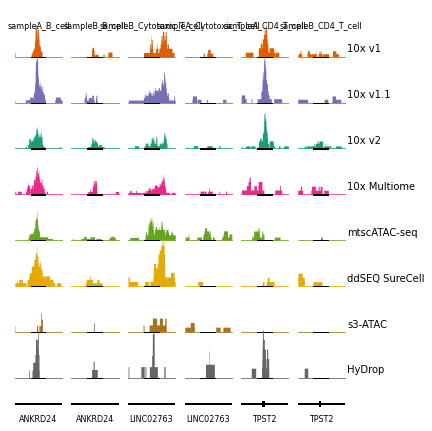

In [348]:
n_cols = (
    len(regions_dict) * 2
)  # times 2 because we draw the male and female coverage for every region
n_rows = len(tech_order)
figsize = (n_cols, n_rows)
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.1)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame


text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.2, hspace=-0.1, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in cell_type_order:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = cell_type_order.index(region_name)

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    bw_ymax = region_max_dict_padded[region_name]

    # you can also set global ymax:
    # bw_ymax = region_max_dict_padded[
    #     max(region_max_dict_padded, key=region_max_dict_padded.get)
    # ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in tech_order:
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0.05,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 0.5],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == cell_type_order[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
                # color=tech_color_palette[key],
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        # add a title only if it's the first row
        if tech_order.index(key) == 0:
            region = regions_dict_padded[region_name]
            length = round((end - start) / 1000)
            label = f"{cell_type_alias_dict[region_name]}"

            ax.set_title(label, fontsize=8, y=0.45)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            # if key in peak_path_dict[region_name].keys():
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            if len(peak_region_intersection) > 0:
                peak_region_intersection = peak_region_intersection.to_dataframe(
                    header=None
                )
                peak_region_intersection = peak_region_intersection.iloc[:, :4]
                peak_region_intersection.columns = "chr start end name".split()

                # now plot the dars in the gridspec
                ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
                for element in peak_region_intersection.index:
                    part = peak_region_intersection.loc[element]
                    peak_start = part["start"]
                    peak_end = part["end"]

                    # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                    # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                    ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

                # figure settings
                ax.set_ylim([-1, +1])
                addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name][key])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name][key]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            if len(dar_region_intersection) > 0:

                dar_region_intersection = dar_region_intersection.iloc[:, :4]
                dar_region_intersection.columns = "chr start end name".split()

                # now plot the dars in the gridspec
                ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
                for element in dar_region_intersection.index:
                    part = dar_region_intersection.loc[element]
                    dar_start = part["start"]
                    dar_end = part["end"]

                    # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                    # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                    ax.plot([dar_start, dar_end], [0, 0], linewidth=8, c=dar_color)

                # figure settings
                ax.set_ylim([-1, +1])
                addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=8)
        addax()

fig.savefig(
    "plts_track/dar_track_malefemale.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/dar_track_malefemale.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

# fig

In [349]:
for cell_type, tech_dict in bw_path_dict_dict.items():
    # print(cell_type)
    for tech, path in tech_dict.items():
        newpath = path.replace("SCREEN_pseudobulk_bw_files/", "")
        print(f"ln {path} {newpath}")

ln male_female_coverage/s3atac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/s3atac__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/10xv1__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/10xv1__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/mtscatac__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/mtscatac__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/10xv2__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/10xv2__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/10xv11__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/10xv11__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/10xmultiome__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/10xmultiome__sampleA_Cytotoxic_T_cell.bw
ln male_female_coverage/hydrop__SCREEN_pseudobulk_bw_files/sampleA_Cytotoxic_T_cell.bw male_female_coverage/hydrop__sampleA_Cy